# Project Assignment Explainable AI [IT790A], 2025 Fall Term

## Task 1: Model Fine-tuning & validation

Group 3:

* Lorenz Koch (a24lorko)

* Kim Wurster (a24kimwu)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBRegressor

import time
import warnings

import joblib
np.random.seed(0)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup and data exploration


In [2]:
df = pd.read_csv('/content/drive/MyDrive/day-bikesharing.csv',parse_dates=['dteday'],index_col=1) # Load the data

In [3]:
df.shape

(731, 15)

In [4]:
def add_features(df):
    df['year'] = df.index.year # yr exists already
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

In [5]:
add_features(df)
df.head(3)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day,dayofweek
dteday,,,,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011,1,1,5
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011,1,2,6
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011,1,3,0


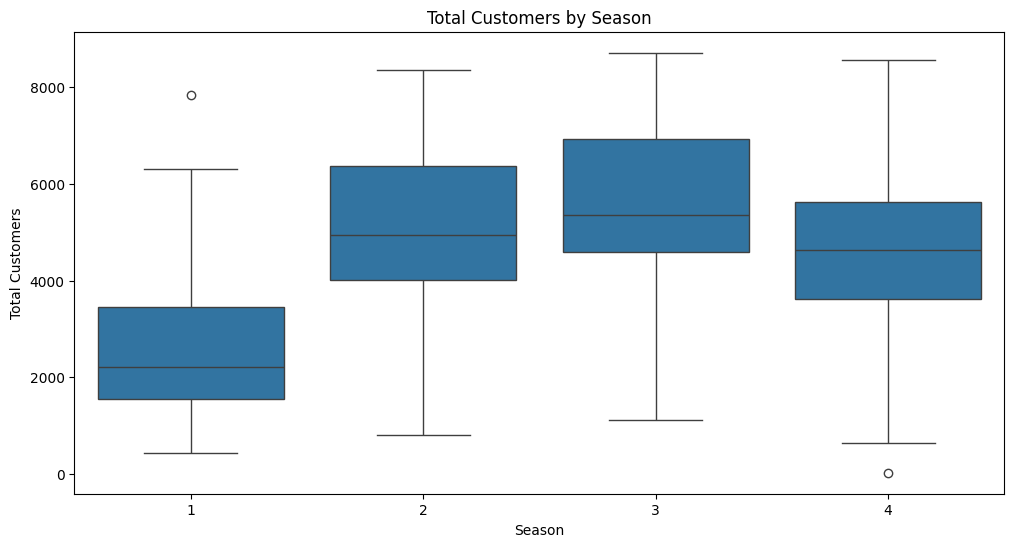

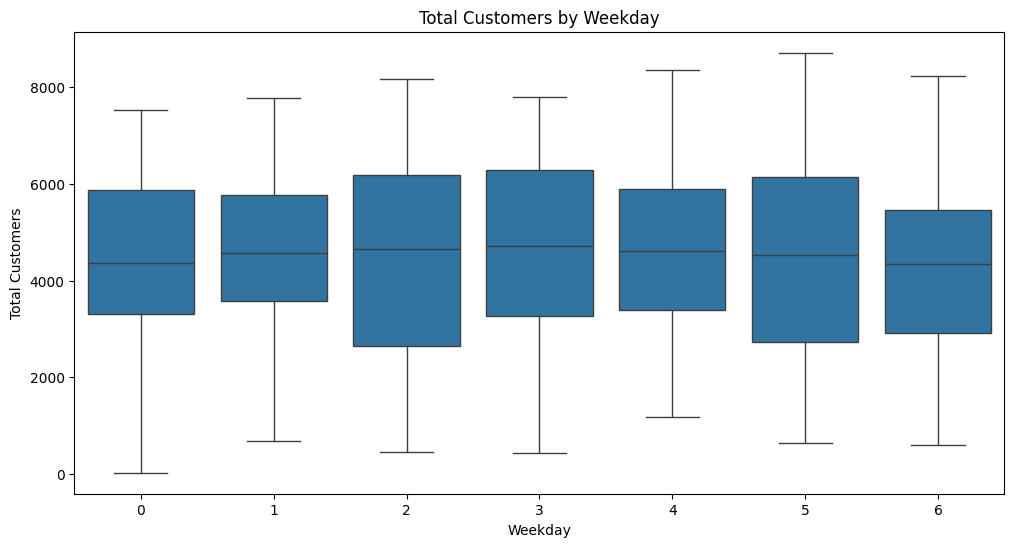

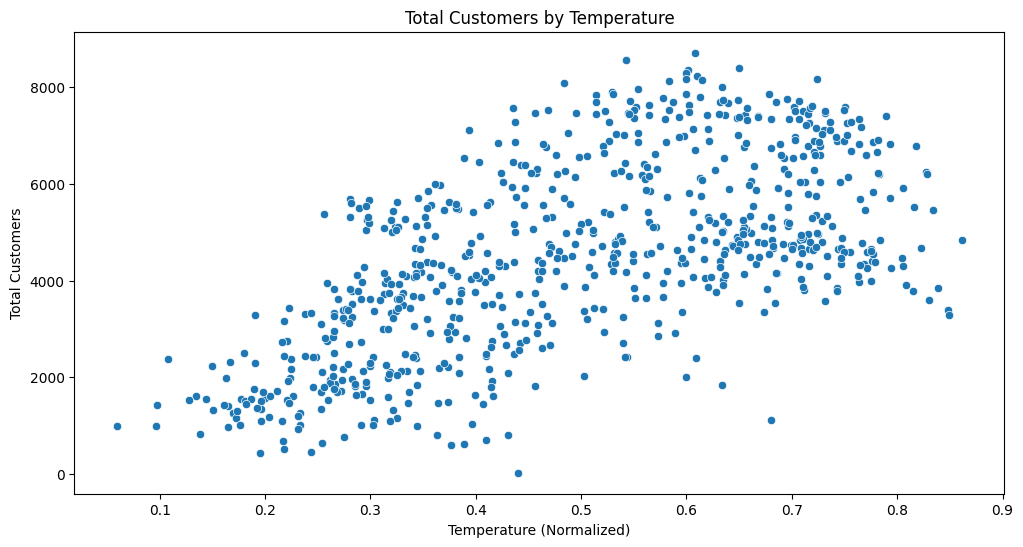

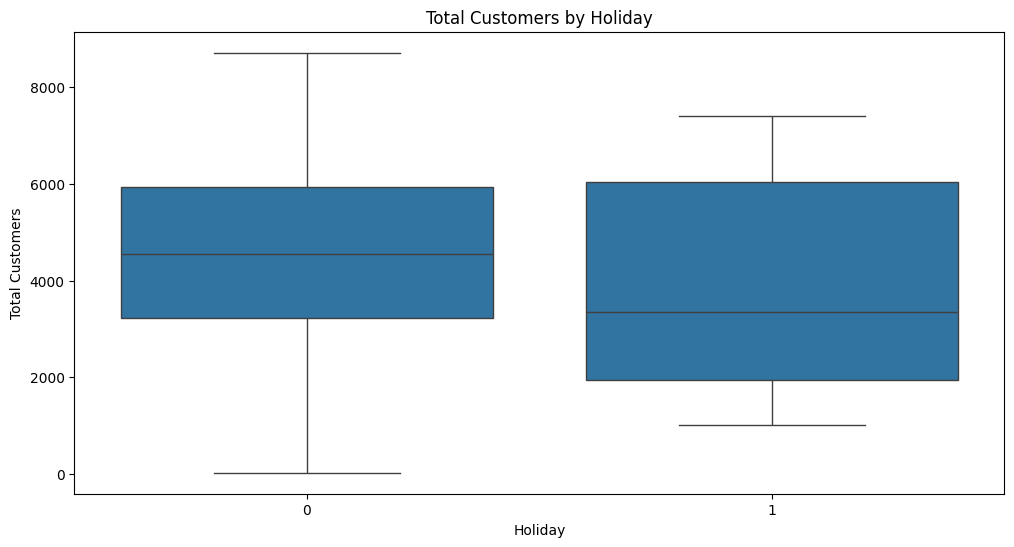

In [6]:
plt.figure(figsize=(12, 6))
sb.boxplot(x='season', y='cnt', data=df)
plt.title('Total Customers by Season')
plt.xlabel('Season')
plt.ylabel('Total Customers')
plt.show()

plt.figure(figsize=(12, 6))
sb.boxplot(x='dayofweek', y='cnt', data=df)
plt.title('Total Customers by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Total Customers')
plt.show()

plt.figure(figsize=(12, 6))
sb.scatterplot(x='temp', y='cnt', data=df)
plt.title('Total Customers by Temperature')
plt.xlabel('Temperature (Normalized)')
plt.ylabel('Total Customers')
plt.show()

plt.figure(figsize=(12, 6))
sb.boxplot(x='holiday', y='cnt', data=df)
plt.title('Total Customers by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Total Customers')
plt.show()

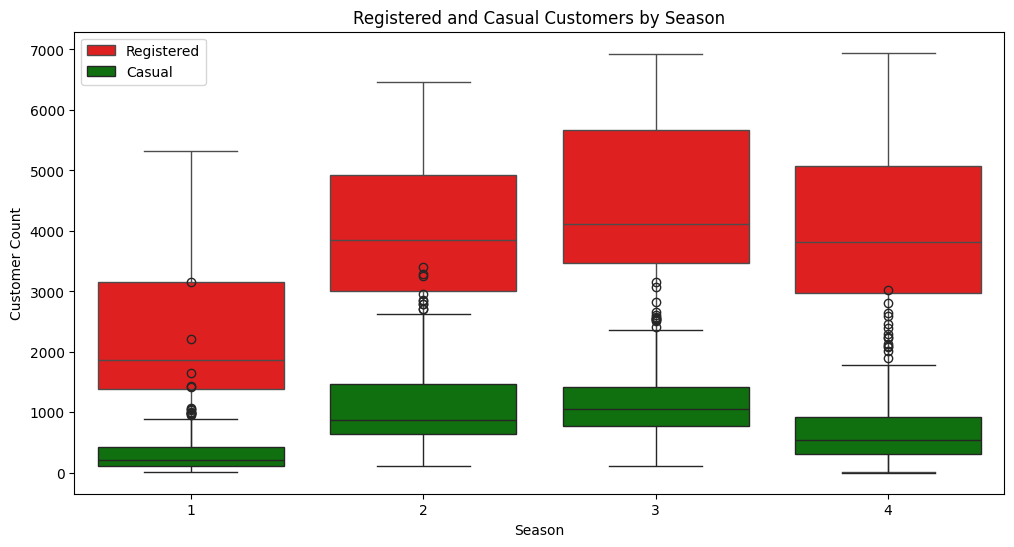

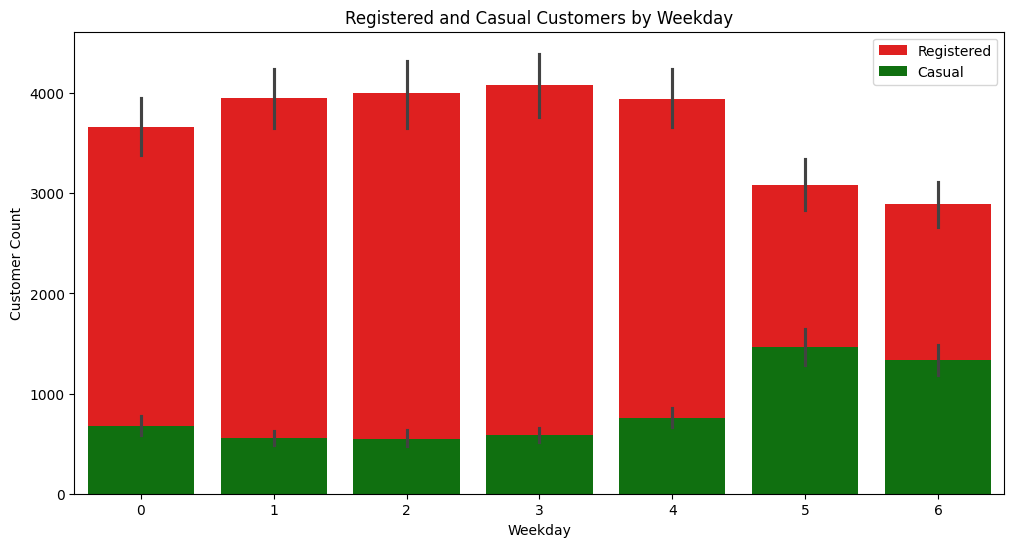

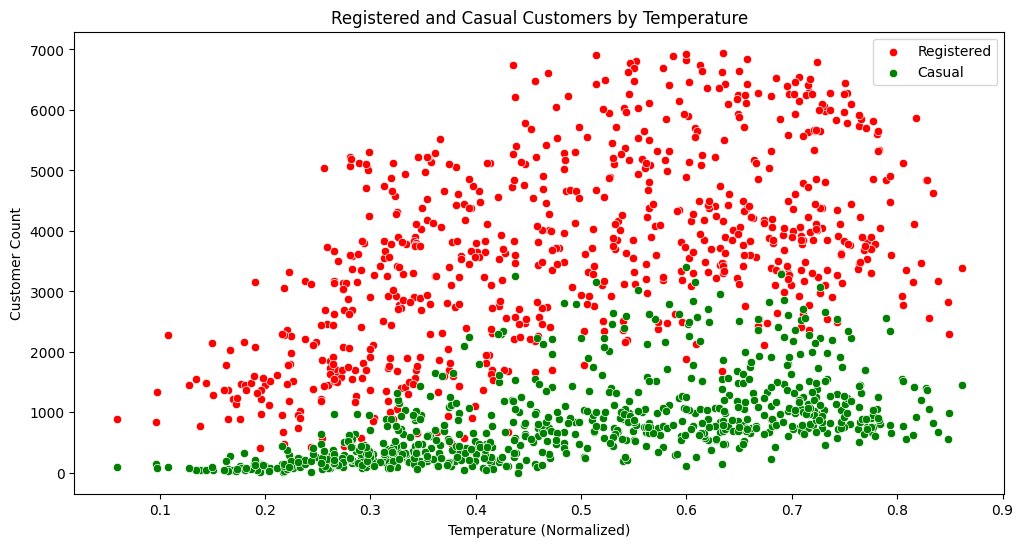

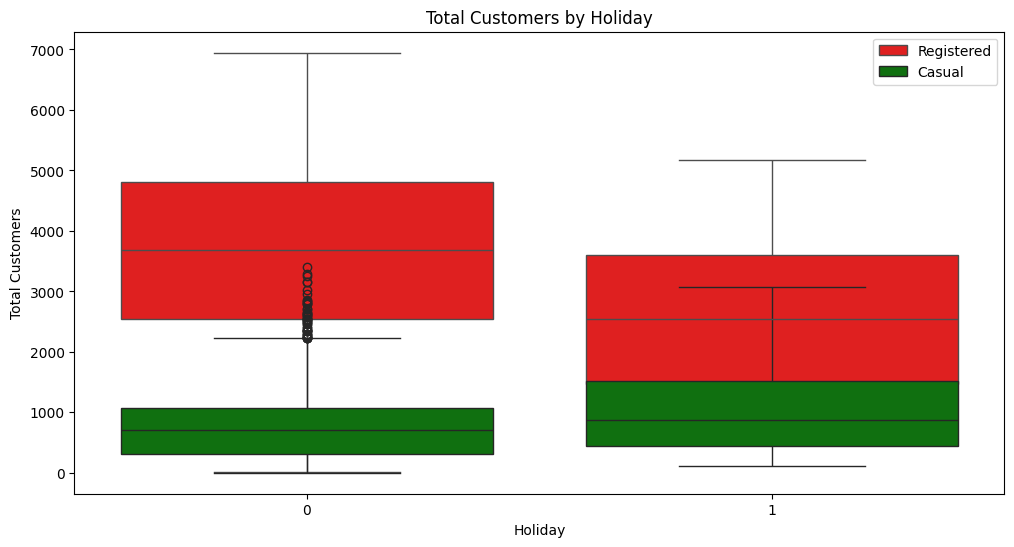

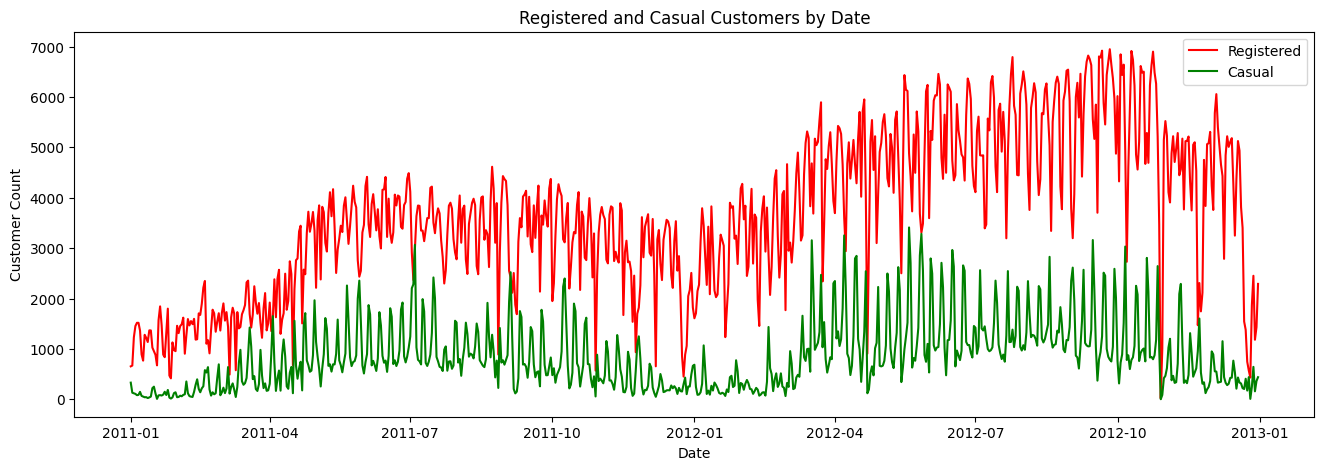

In [7]:
plt.figure(figsize=(12, 6))
sb.boxplot(x='season', y='registered', data=df, color='red', label='Registered')
sb.boxplot(x='season', y='casual', data=df, color='green', label='Casual')
plt.title('Registered and Casual Customers by Season')
plt.xlabel('Season')
plt.ylabel('Customer Count')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sb.barplot(x='dayofweek', y='registered', data=df, color='red', label='Registered')
sb.barplot(x='dayofweek', y='casual', data=df, color='green', label='Casual')
plt.title('Registered and Casual Customers by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Customer Count')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sb.scatterplot(x='temp', y='registered', data=df, color='red', label='Registered')
sb.scatterplot(x='temp', y='casual', data=df, color='green', label='Casual')
plt.title('Registered and Casual Customers by Temperature')
plt.xlabel('Temperature (Normalized)')
plt.ylabel('Customer Count')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sb.boxplot(x='holiday', y='registered', data=df, color='red', label='Registered')
sb.boxplot(x='holiday', y='casual', data=df, color='green', label='Casual')
plt.title('Total Customers by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Total Customers')
plt.show()

plt.figure(figsize=(16,5))
sb.lineplot(x='dteday', y='registered', data=df, color='red', label='Registered')
sb.lineplot(x='dteday', y='casual', data=df, color='green', label='Casual')
plt.title('Registered and Casual Customers by Date')
plt.xlabel('Date')
plt.ylabel('Customer Count')
plt.legend()
plt.show()

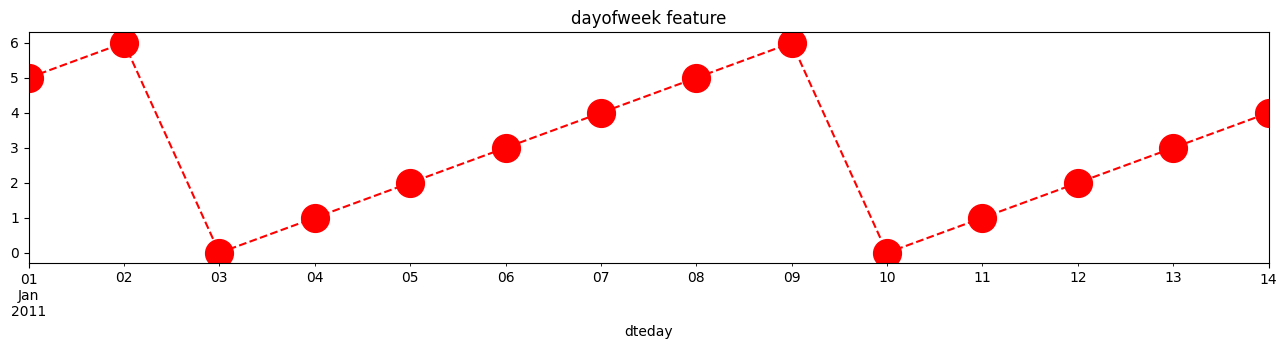

In [8]:
plt.figure(figsize=(16,3))
df['dayofweek'][:14].plot(linestyle='--', marker='o', color='r', ms=20,
                       title='dayofweek feature')
plt.show()

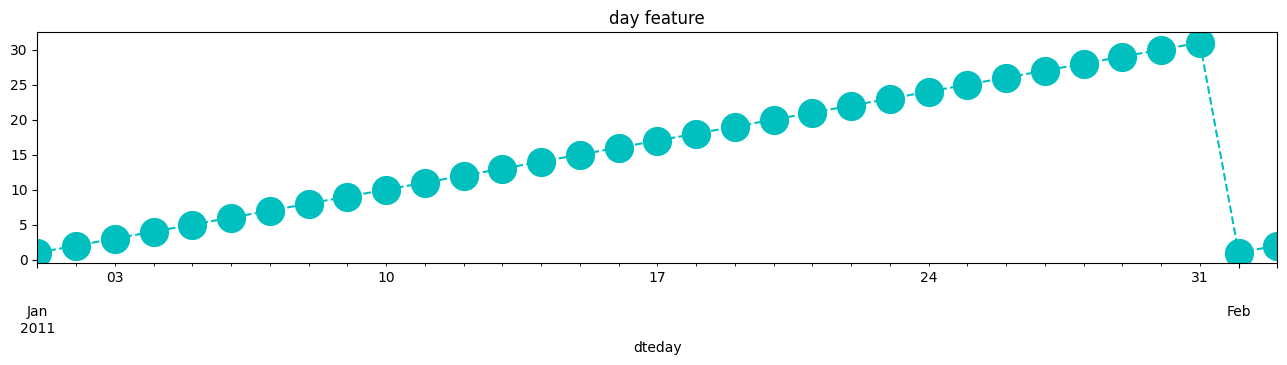

In [9]:
# Day feature shows whether it is a start of the month or the end of the month (1 to 30 or 31).
plt.figure(figsize=(16,3))
df['day'][:33].plot(linestyle='--', marker='o', color='c', ms=20, title='day feature')
plt.show()

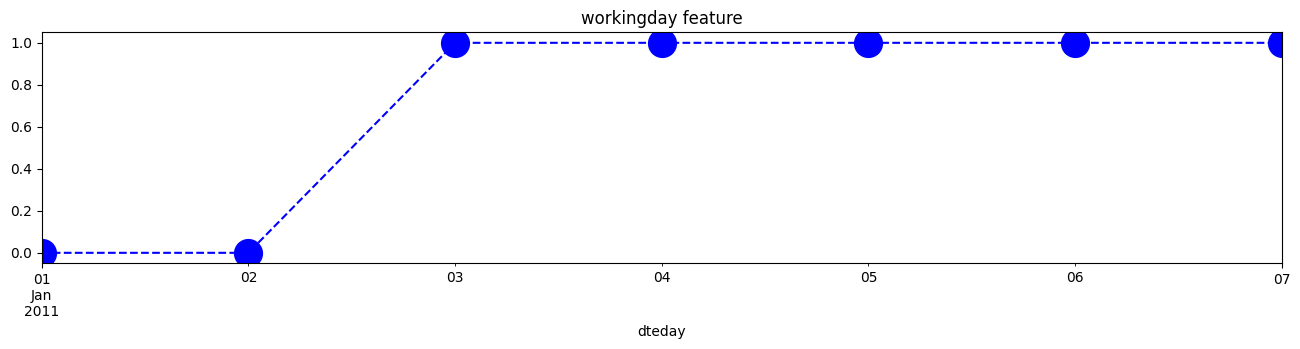

In [10]:
plt.figure(figsize=(16,3))
df['workingday'][:7].plot(linestyle='--', marker='o', color='b', ms=20, title='workingday feature')
plt.show()

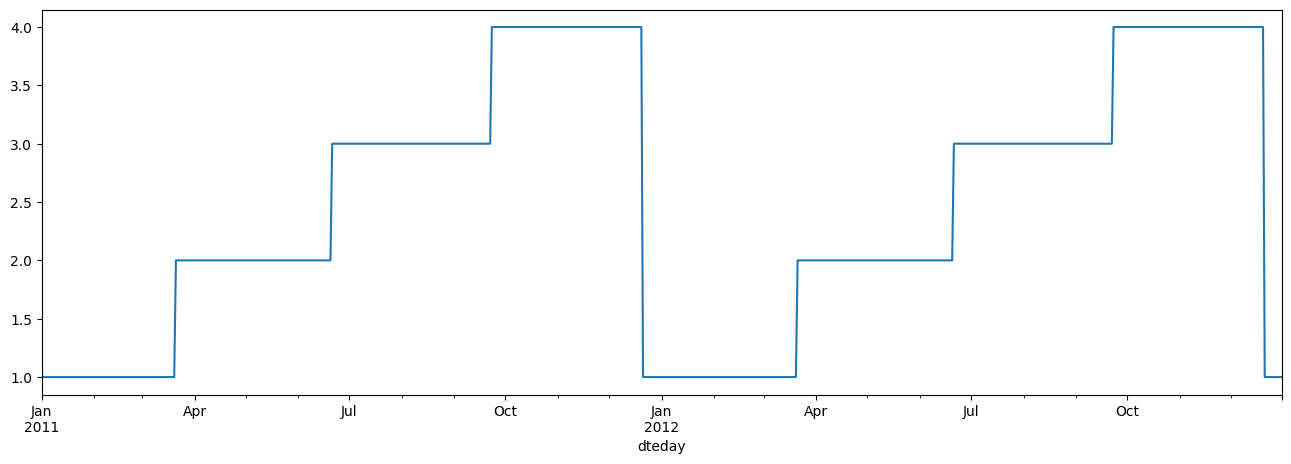

In [11]:
plt.figure(figsize=(16,5))
df['season'].plot()
plt.show()

In [12]:
df.season.value_counts()

,count
season,
3,188
2,184
1,181
4,178


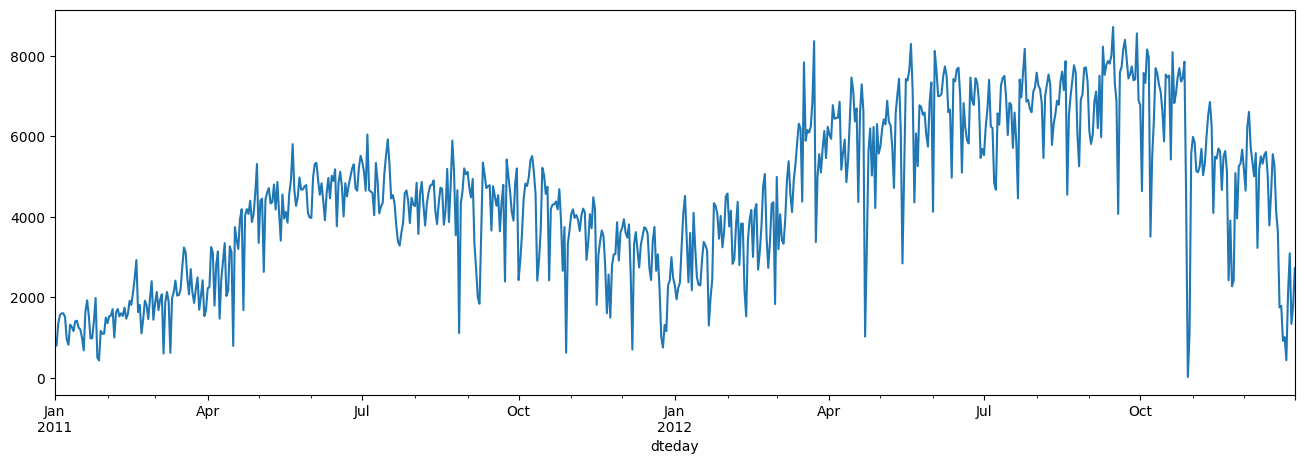

In [13]:
plt.figure(figsize=(16,5))
df['cnt'].plot()
plt.show()

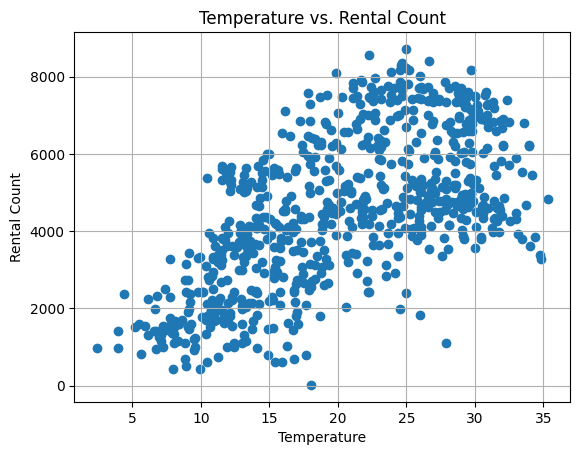

In [14]:
plt.scatter(x=df.temp*41,y=df["cnt"]) # denormalize temperature by multiplying 41
plt.grid(True)
plt.xlabel('Temperature')
plt.ylabel('Rental Count')
plt.title('Temperature vs. Rental Count')
plt.show()

Text(0.5, 1.0, 'Average Rental Count by Month')

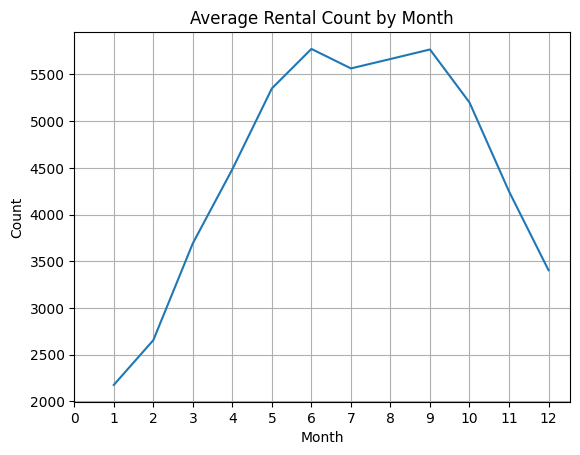

In [15]:
# from January to April, the demand is relatively low due to Winter
#(there are not a lot of people that's brave enough to bike on icy road, are there?).
# And the peak demand happends around Summer time (from May to October) and drop again.
group_month = df.groupby(['month'])
average_by_month = group_month['cnt'].mean()

plt.plot(average_by_month.index,average_by_month)
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(np.arange(13))
plt.grid(True)
plt.title('Average Rental Count by Month')

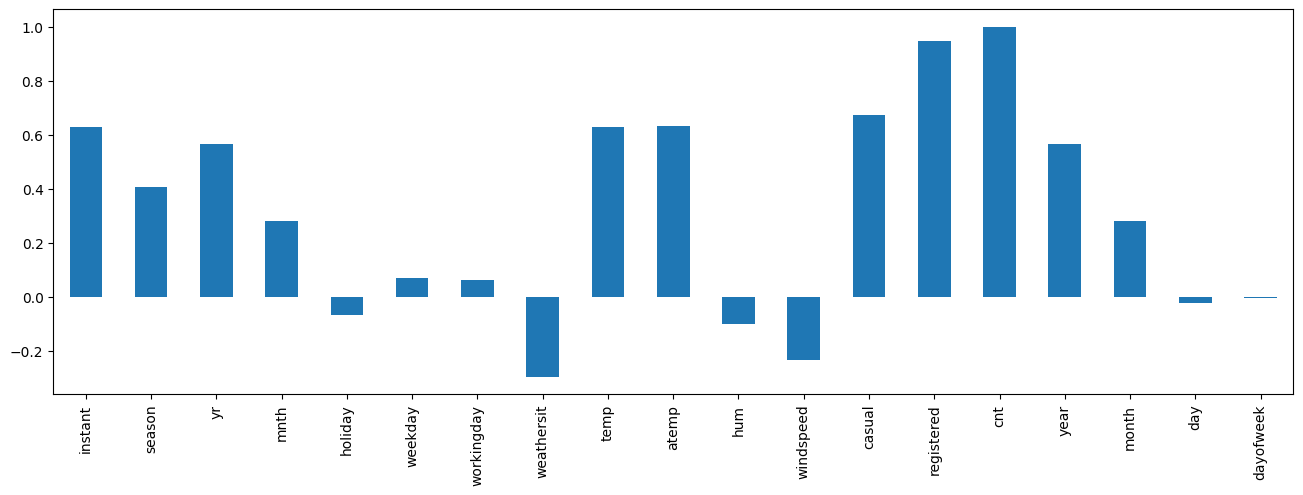

In [16]:
#correlation of total cnt with other variables
plt.figure(figsize=(16,5))
df.corr()['cnt'].plot(kind='bar')
plt.show()

In [17]:
#This is the normalized version.
# temp: The values are divided to 41 (max)
# atemp: The values are divided to 50 (max)
# hum: The values are divided to 100 (max)
# windspeed: The values are divided to 67 (max)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


In [18]:
df.dtypes

,0
instant,int64
season,int64
yr,int64
mnth,int64
holiday,int64
weekday,int64
workingday,int64
weathersit,int64
temp,float64
atemp,float64


# Data cleaning

# Categorical variables

In [19]:
# Define the categorical variables
cat_var = ['season', 'holiday', 'workingday', 'weathersit', 'year']

In [20]:
# OneHotEncoder
ohe = OneHotEncoder(categories = 'auto')

In [21]:
# Fit the categorical variables to the encoder
encodeddf = ohe.fit_transform(df[cat_var])

In [22]:
# Create a DataFrame with the encoded value information
cat_df = pd.DataFrame(data = encodeddf.toarray(), columns = ohe.get_feature_names_out(cat_var))
cat_df

,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,year_2011,year_2012
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [23]:
# rename the column names from 1,2,3,4 to spring, summer, fall, winter
cat_df.rename(columns={'season_1': 'winter', 'season_2': 'spring', 'season_3': 'summer', 'season_4': 'fall'}, inplace=True)
cat_df.rename(columns={'weathersit_1': 'clear', 'weathersit_2': 'cloudy', 'weathersit_3': 'lightsnow.rain'}, inplace=True)
cat_df

,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,lightsnow.rain,year_2011,year_2012
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


# Numerical variables

Machine learning is sensitive to the relative scales of numerical variables. The range of all variables need to be normalized so that each feature contributes approximately proportionately to the calculation.

In [24]:
# Define the numerical variables
num_var = ['temp', 'atemp', 'hum', 'windspeed', 'month', 'day', 'dayofweek']

Create standardized, normalized

In [25]:
# StandardScaler object
scaler = StandardScaler()

In [26]:
# Fit the data to the scaler
numscaled = scaler.fit_transform(df[num_var])

Keep the original for later view

In [27]:
# for inverse transformation
inversed = scaler.inverse_transform(numscaled)
print(inversed)

[[ 0.344167  0.363625  0.805833 ...  1.        1.        5.      ]
 [ 0.363478  0.353739  0.696087 ...  1.        2.        6.      ]
 [ 0.196364  0.189405  0.437273 ...  1.        3.        0.      ]
 ...
 [ 0.253333  0.2424    0.752917 ... 12.       29.        5.      ]
 [ 0.255833  0.2317    0.483333 ... 12.       30.        6.      ]
 [ 0.215833  0.223487  0.5775   ... 12.       31.        0.      ]]


In [28]:
# Create DataFrame with original data
inversed_df = pd.DataFrame(data = inversed, columns = num_var)
inversed_df

# Calculate based on UCI info to retrieve the actual temperature and weather information
#temp : Normalized temperature in Celsius. The values are divided to 41 (max)
#atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
#hum: Normalized humidity. The values are divided to 100 (max)
#windspeed: Normalized wind speed. The values are divided to 67 (max)
inversed_origin = pd.concat([inversed_df.iloc[:,0] * 41, #temperature
           inversed_df.iloc[:,1] * 50,                   #feeling temperature
           inversed_df.iloc[:,2] * 100,                  #humidity
           inversed_df.iloc[:,3] * 67],                  #wind speed
          axis=1)
inversed_origin

,temp,atemp,hum,windspeed
0,14.110847,18.18125,80.5833,10.749882
1,14.902598,17.68695,69.6087,16.652113
2,8.050924,9.47025,43.7273,16.636703
3,8.200000,10.60610,59.0435,10.739832
4,9.305237,11.46350,43.6957,12.522300
...,...,...,...,...
726,10.420847,11.33210,65.2917,23.458911
727,10.386653,12.75230,59.0000,10.416557
728,10.386653,12.12000,75.2917,8.333661
729,10.489153,11.58500,48.3333,23.500518


Text(0.5, 0, 'daily time (# rows)')

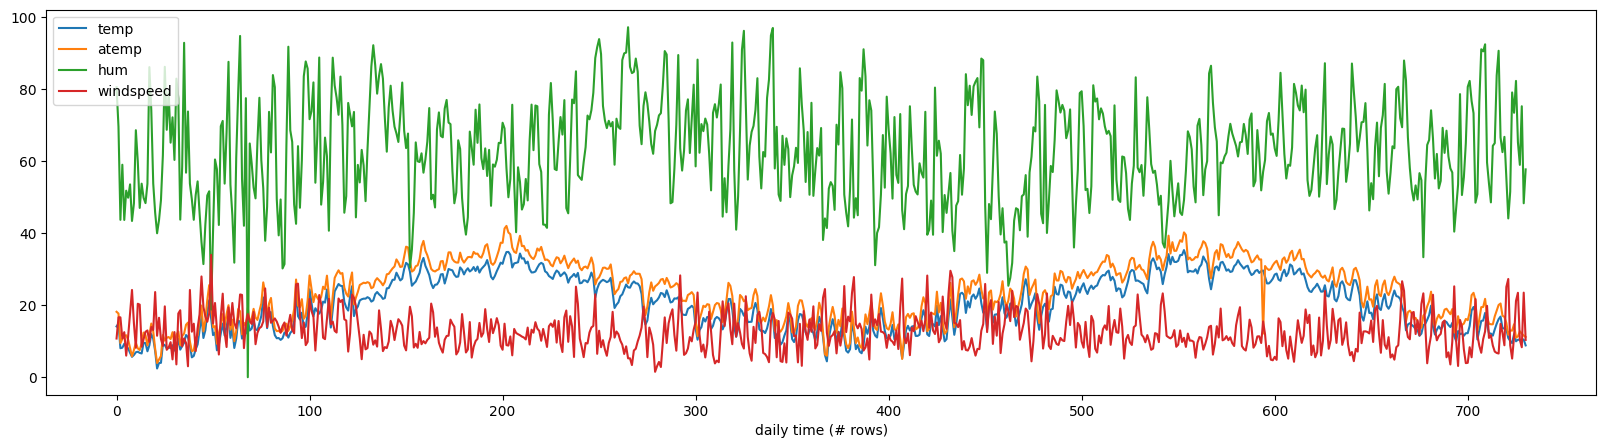

In [29]:
# timeseries of temp, atemp, humidity, windspeed
ax = inversed_origin.set_index(inversed_origin.index).plot(figsize=(20,5))
ax.set_xlabel('daily time (# rows)')

In [30]:
X_original = pd.concat([cat_df, inversed_origin, inversed_df[['month', 'day', 'dayofweek']]], axis=1)
X_original # Use this for SHAP plot view

,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,lightsnow.rain,year_2011,year_2012,temp,atemp,hum,windspeed,month,day,dayofweek
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,14.110847,18.18125,80.5833,10.749882,1.0,1.0,5.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,14.902598,17.68695,69.6087,16.652113,1.0,2.0,6.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,8.050924,9.47025,43.7273,16.636703,1.0,3.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,8.200000,10.60610,59.0435,10.739832,1.0,4.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,9.305237,11.46350,43.6957,12.522300,1.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,10.420847,11.33210,65.2917,23.458911,12.0,27.0,3.0
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,10.386653,12.75230,59.0000,10.416557,12.0,28.0,4.0
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,10.386653,12.12000,75.2917,8.333661,12.0,29.0,5.0
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,10.489153,11.58500,48.3333,23.500518,12.0,30.0,6.0


In [31]:
# Create DataFrame with numerically scaled data
num_df = pd.DataFrame(data = numscaled, columns = num_var)
num_df

,temp,atemp,hum,windspeed,month,day,dayofweek
0,-0.826662,-0.679946,1.250171,-0.387892,-1.600161,-1.674108,0.996930
1,-0.721095,-0.740652,0.479113,0.749602,-1.600161,-1.560522,1.496077
2,-1.634657,-1.749767,-1.339274,0.746632,-1.600161,-1.446936,-1.498809
3,-1.614780,-1.610270,-0.263182,-0.389829,-1.600161,-1.333351,-0.999661
4,-1.467414,-1.504971,-1.341494,-0.046307,-1.600161,-1.219765,-0.500513
...,...,...,...,...,...,...,...
726,-1.318665,-1.521108,0.175807,2.061426,1.588660,1.279122,-0.001366
727,-1.323224,-1.346690,-0.266238,-0.452131,1.588660,1.392707,0.497782
728,-1.323224,-1.424344,0.878392,-0.853552,1.588660,1.506293,0.996930
729,-1.309558,-1.490049,-1.015664,2.069444,1.588660,1.619879,1.496077


# Modelling preparation

Define X (input): Concatenate one hot encoded categorical + normalized numerical data

In [32]:
Xdf = pd.concat([cat_df, num_df], axis = 1)
print(Xdf.shape)
Xdf.head(5)

(731, 20)


,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,lightsnow.rain,year_2011,year_2012,temp,atemp,hum,windspeed,month,day,dayofweek
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.600161,-1.674108,0.996930
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.600161,-1.560522,1.496077
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.634657,-1.749767,-1.339274,0.746632,-1.600161,-1.446936,-1.498809
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.600161,-1.333351,-0.999661
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.600161,-1.219765,-0.500513


In [33]:
# Save column names for SHAP usage
NAMES = Xdf.columns
NAMES

Index(['winter', 'spring', 'summer', 'fall', 'holiday_0', 'holiday_1',
       'workingday_0', 'workingday_1', 'clear', 'cloudy', 'lightsnow.rain',
       'year_2011', 'year_2012', 'temp', 'atemp', 'hum', 'windspeed', 'month',
       'day', 'dayofweek'],
      dtype='object')

<Axes: >

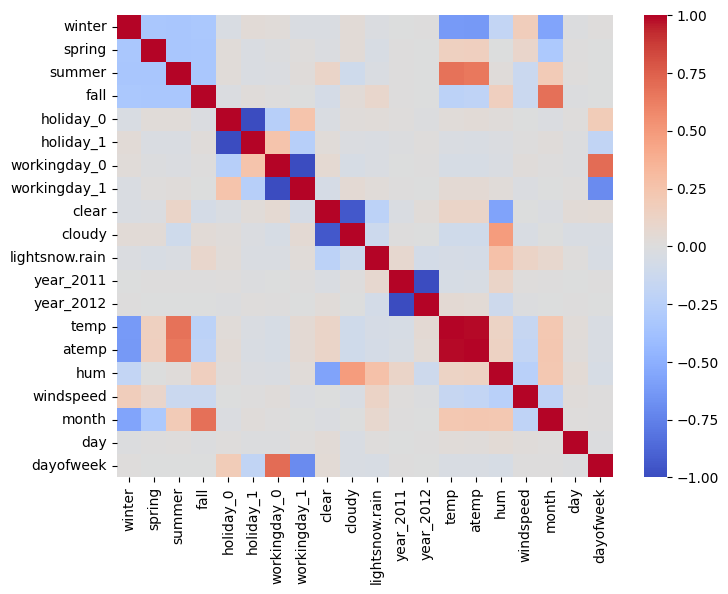

In [34]:
plt.subplots(figsize=(8, 6))
sb.heatmap(Xdf.corr(), cmap='coolwarm')

In [35]:
# Check if there is any non available
Xdf.isna().any().sum()

np.int64(0)

### Total number of customers (count)

Define Y (to predict): Extract target

In [36]:
# Here, indicate which target to predict (cnt or casual or registered)
# For the different models for each customer type in the assignment, change the target
to_predict = 'cnt'

In [37]:
# Here, indicate which target to predict (cnt or casual or registered)
y = df[to_predict]

# Normalize target data: Calculate mean and standard deviation
y_mu = y.mean(0)
y_sd = y.std(0)

print('y mean:', y_mu, ' y std:' , y_sd)

y_norm = (y - y_mu) / y_sd
y_norm = y_norm.values.ravel() #dataframe to 1D array
#y_norm

y mean: 4504.3488372093025  y std: 1937.2114516187678


In [38]:
len(y)

731

In [39]:
# to verify, leave a whole dataframe with x and y together
tdf = pd.concat([Xdf, pd.DataFrame(y.values)], axis = 1)
tdf.rename(columns={0:'cnt'}, inplace=True) #change the column name
tdf

,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,...,year_2011,year_2012,temp,atemp,hum,windspeed,month,day,dayofweek,cnt
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.600161,-1.674108,0.996930,985
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.600161,-1.560522,1.496077,801
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.634657,-1.749767,-1.339274,0.746632,-1.600161,-1.446936,-1.498809,1349
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.600161,-1.333351,-0.999661,1562
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.600161,-1.219765,-0.500513,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,-1.318665,-1.521108,0.175807,2.061426,1.588660,1.279122,-0.001366,2114
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,-1.323224,-1.346690,-0.266238,-0.452131,1.588660,1.392707,0.497782,3095
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,-1.323224,-1.424344,0.878392,-0.853552,1.588660,1.506293,0.996930,1341
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,-1.309558,-1.490049,-1.015664,2.069444,1.588660,1.619879,1.496077,1796


Split training and test data

In [40]:
# Split the data into training, validation, and test data:
X_train, X_test, y_train, y_test = train_test_split(Xdf, y_norm, test_size = 0.2, random_state=1)
# Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

### Casual Customers

In [41]:
to_predict_casual = 'casual'

In [42]:
# Here, indicate which target to predict (cnt or casual or registered)
y_casual = df[to_predict_casual]

# Normalize target data: Calculate mean and standard deviation
y_mu_casual = y_casual.mean(0)
y_sd_casual = y_casual.std(0)

print('y mean:', y_mu_casual, ' y std:' , y_sd_casual)

y_norm_casual = (y_casual - y_mu_casual) / y_sd_casual
y_norm_casual = y_norm_casual.values.ravel() #dataframe to 1D array
#y_norm_casual

y mean: 848.1764705882352  y std: 686.6224882846549


In [43]:
len(y_casual)

731

In [44]:
# to verify, leave a whole dataframe with x and y together
tdf_casual = pd.concat([Xdf, pd.DataFrame(y_casual.values)], axis = 1)
tdf_casual.rename(columns={0:'casual'}, inplace=True) #change the column name
tdf_casual

,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,...,year_2011,year_2012,temp,atemp,hum,windspeed,month,day,dayofweek,casual
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.600161,-1.674108,0.996930,331
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.600161,-1.560522,1.496077,131
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.634657,-1.749767,-1.339274,0.746632,-1.600161,-1.446936,-1.498809,120
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.600161,-1.333351,-0.999661,108
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.600161,-1.219765,-0.500513,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,-1.318665,-1.521108,0.175807,2.061426,1.588660,1.279122,-0.001366,247
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,-1.323224,-1.346690,-0.266238,-0.452131,1.588660,1.392707,0.497782,644
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,-1.323224,-1.424344,0.878392,-0.853552,1.588660,1.506293,0.996930,159
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,-1.309558,-1.490049,-1.015664,2.069444,1.588660,1.619879,1.496077,364


In [45]:
# Split the data into training, validation, and test data:
X_train_casual, X_test_casual, y_train_casual, y_test_casual = train_test_split(Xdf, y_norm_casual, test_size = 0.2, random_state=1)
# Validation set
X_train_casual, X_val_casual, y_train_casual, y_val_casual = train_test_split(X_train_casual, y_train_casual, test_size=0.2, random_state=1)

### Registered Customers

In [46]:
to_predict_registered = 'registered'

In [47]:
# Here, indicate which target to predict (cnt or casual or registered)
y_registered = df[to_predict_registered]

# Normalize target data: Calculate mean and standard deviation
y_mu_registered = y_registered.mean(0)
y_sd_registered = y_registered.std(0)

print('y mean:', y_mu_registered, ' y std:' , y_sd_registered)

y_norm_registered = (y_registered - y_mu_registered) / y_sd_registered
y_norm_registered = y_norm_registered.values.ravel() #dataframe to 1D array
#y_norm_registered

y mean: 3656.172366621067  y std: 1560.2563770194527


In [48]:
len(y_registered)

731

In [49]:
# to verify, leave a whole dataframe with x and y together
tdf_registered = pd.concat([Xdf, pd.DataFrame(y_registered.values)], axis = 1)
tdf_registered.rename(columns={0:'registered'}, inplace=True) #change the column name
tdf_registered

,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,...,year_2011,year_2012,temp,atemp,hum,windspeed,month,day,dayofweek,registered
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.600161,-1.674108,0.996930,654
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.600161,-1.560522,1.496077,670
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.634657,-1.749767,-1.339274,0.746632,-1.600161,-1.446936,-1.498809,1229
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.600161,-1.333351,-0.999661,1454
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.600161,-1.219765,-0.500513,1518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,-1.318665,-1.521108,0.175807,2.061426,1.588660,1.279122,-0.001366,1867
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,-1.323224,-1.346690,-0.266238,-0.452131,1.588660,1.392707,0.497782,2451
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,-1.323224,-1.424344,0.878392,-0.853552,1.588660,1.506293,0.996930,1182
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,-1.309558,-1.490049,-1.015664,2.069444,1.588660,1.619879,1.496077,1432


In [50]:
# Split the data into training, validation, and test data:
X_train_registered, X_test_registered, y_train_registered, y_test_registered = train_test_split(Xdf, y_norm_registered, test_size = 0.2, random_state=1)
# Validation set
X_train_registered, X_val_registered, y_train_registered, y_val_registered = train_test_split(X_train_registered, y_train_registered, test_size=0.2, random_state=1)

# Grid search and modeling

In [51]:
def refine_from_search(random_search, X, y, refinement_factor=0.5, n_iter=100, cv=5, random_state=42):

    prev_best = random_search.best_params_
    prev_dist = random_search.param_distributions

    # Define valid ranges for XGBRegressor hyperparameters
    param_bounds = {
        "n_estimators": (1, None),
        "learning_rate": (1e-5, None),
        "max_depth": (1, None),
        "min_child_weight": (0, None),
        "gamma": (0, None),
        "subsample": (1e-5, 1.0),
        "colsample_bytree": (1e-5, 1.0),
        "reg_alpha": (0, None),
        "reg_lambda": (0, None),
    }

    refined_params = {}
    for param, dist in prev_dist.items():
        best_val = prev_best[param]
        low, high = None, None

        if isinstance(dist, list):
            if all(isinstance(v, (int, float)) for v in dist):
                span = max(dist) - min(dist)
                delta = span * refinement_factor / 2
                low, high = best_val - delta, best_val + delta

                # enforce valid ranges
                min_bound, max_bound = param_bounds.get(param, (None, None))
                if min_bound is not None:
                    low = max(low, min_bound)
                if max_bound is not None:
                    high = min(high, max_bound)

                # preserve int parameters
                if all(isinstance(v, int) for v in dist):
                    refined_params[param] = list(
                        range(int(round(low)), int(round(high)) + 1)
                    )
                    if not refined_params[param]:  # fallback if empty
                        refined_params[param] = [int(round(best_val))]
                else:
                    refined_params[param] = np.linspace(low, high, len(dist))
            else:
                refined_params[param] = dist  # categorical
        else:
            refined_params[param] = [best_val]

    new_search = RandomizedSearchCV(
        estimator=random_search.estimator,
        param_distributions=refined_params,
        n_iter=n_iter,
        cv=cv,
        scoring=random_search.scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=1,
    )
    new_search.fit(X, y)

    return new_search


In [52]:
# this is just the normal function copied with changes so it works with a gridsearch input
def refine_from_search_casual_only(random_search, X, y, refinement_factor=0.5, n_iter=100, cv=5, random_state=42):

    prev_best = random_search.best_params_
    prev_dist = random_search.param_grid

    # Define valid ranges for XGBRegressor hyperparameters
    param_bounds = {
        "n_estimators": (1, None),
        "learning_rate": (1e-5, None),
        "max_depth": (1, None),
        "min_child_weight": (0, None),
        "gamma": (0, None),
        "subsample": (1e-5, 1.0),
        "colsample_bytree": (1e-5, 1.0),
        "reg_alpha": (0, None),
        "reg_lambda": (0, None),
    }

    refined_params = {}
    for param, dist in prev_dist.items():
        best_val = prev_best[param]
        low, high = None, None

        if isinstance(dist, list):
            if all(isinstance(v, (int, float)) for v in dist):
                span = max(dist) - min(dist)
                delta = span * refinement_factor / 2
                low, high = best_val - delta, best_val + delta

                # enforce valid ranges
                min_bound, max_bound = param_bounds.get(param, (None, None))
                if min_bound is not None:
                    low = max(low, min_bound)
                if max_bound is not None:
                    high = min(high, max_bound)

                # preserve int parameters
                if all(isinstance(v, int) for v in dist):
                    refined_params[param] = list(
                        range(int(round(low)), int(round(high)) + 1)
                    )
                    if not refined_params[param]:  # fallback if empty
                        refined_params[param] = [int(round(best_val))]
                else:
                    refined_params[param] = np.linspace(low, high, len(dist))
            else:
                refined_params[param] = dist  # categorical
        else:
            refined_params[param] = [best_val]

    new_search = RandomizedSearchCV(
        estimator=random_search.estimator,
        param_distributions=refined_params,
        n_iter=n_iter,
        cv=cv,
        scoring=random_search.scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=1,
    )
    new_search.fit(X, y)

    return new_search


In [53]:
# params = {
#     'n_estimators': [500, 1000, 1200, 1500],
#     'learning_rate': [0.005, 0.01, 0.1],
#     'max_depth': [1, 3, 4, 5],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.5, 1, 5],
#     'subsample': [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.1, 1, 10, 30],
#     'reg_lambda': [0, 5, 10, 20],
# }

# clf = XGBRegressor(tree_method='hist', eval_metric='rmse')

# random_search_initial = RandomizedSearchCV(
#     estimator=clf,
#     param_distributions=params,
#     n_iter=100,
#     scoring='r2',  #'neg_mean_squared_error'
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# t0 = time.time()
# random_search_initial.fit(X_train, y_train)
# t1 = time.time()
# print(t1-t0, " sec taken")

# random_search = refine_from_search(random_search_initial, X_train, y_train)


In [54]:
# t0 = time.time()
# random_search.fit(X_train, y_train)
# t1 = time.time()
# print(t1-t0, " sec taken")

In [55]:
# print("parameters:", random_search.best_params_)
# print("r2 score:", random_search.best_score_)

In [56]:
parameters = {'subsample': np.float64(0.6749999999999999), 'reg_lambda': 2, 'reg_alpha': np.float64(0.0), 'n_estimators': 807, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': np.float64(0.01688), 'gamma': np.float64(0.0), 'colsample_bytree': np.float64(0.9)}

In [57]:
# # param ranges were based on previous tries
# params_casual = {
#     'n_estimators': [1500, 2000],
#     'learning_rate': [0.01, 0.02, 0.05],
#     'max_depth': [5, 6, 7, 8],
#     'min_child_weight': [4, 7, 10],
#     'gamma': [0, 1, 5],
#     'subsample': [0.3, 0.6, 0.9],
#     'colsample_bytree': [0.4, 0.6, 0.9],
#     'reg_alpha': [0, 0.1],
#     'reg_lambda': [15, 20, 25],
# }


# clf_casual = XGBRegressor(tree_method='hist', eval_metric='rmse')

# random_search_casual_initial = GridSearchCV(
#     estimator=clf_casual,
#     param_grid=params_casual,
#     scoring='r2',  #'neg_mean_squared_error'
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )

# t0 = time.time()
# random_search_casual_initial.fit(X_train_casual, y_train_casual)
# t1 = time.time()
# print(t1-t0, " sec taken")

# random_search_casual = refine_from_search(random_search_casual_initial, X_train_casual, y_train_casual)

In [58]:
# t0 = time.time()
# random_search_casual.fit(X_train_casual, y_train_casual)
# t1 = time.time()
# print(t1-t0, " sec taken")

In [59]:
# print("parameters_casual:", random_search_casual.best_params_)
# print("r2 score_casual:", random_search_casual.best_score_)

In [60]:
parameters_casual = {'subsample': 0.6, 'reg_lambda': 22, 'reg_alpha': 0.07500000000000001, 'n_estimators': 1936, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.475}

In [61]:
# params_registered = {
#     'n_estimators': [200, 500, 800],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'max_depth': [5, 7, 9, 12],
#     'min_child_weight': [1, 3, 5, 10],
#     'gamma': [0, 0.5, 1, 5],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.01, 0.1, 1],
#     'reg_lambda': [1, 5, 10, 20],
# }


# clf_registered = XGBRegressor(tree_method='hist', eval_metric='rmse')

# random_search_registered_initial = RandomizedSearchCV(
#     estimator=clf_registered,
#     param_distributions=params_registered,
#     n_iter=50,
#     scoring='r2',  #'neg_mean_squared_error'
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# t0 = time.time()
# random_search_registered_initial.fit(X_train_registered, y_train_registered)
# t1 = time.time()
# print(t1-t0, " sec taken")

# random_search_registered = refine_from_search(random_search_registered_initial, X_train_registered, y_train_registered)

In [62]:
# t0 = time.time()
# random_search_registered.fit(X_train_registered, y_train_registered)
# t1 = time.time()
# print(t1-t0, " sec taken")

In [63]:
# print("parameters_registered:", random_search_registered.best_params_)
# print("r2 score_registered:", random_search_registered.best_score_)

In [64]:
parameters_registered = {'subsample': np.float64(0.9), 'reg_lambda': 8, 'reg_alpha': np.float64(0.17333333333333334), 'n_estimators': 488, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': np.float64(0.15250000000000002), 'gamma': np.float64(0.0), 'colsample_bytree': np.float64(0.9)}

# Train with best parameters

In [65]:
from sklearn._config import get_config, set_config
set_config(print_changed_only=False)

In [67]:
#xgbmodel = xgb.XGBRegressor(**random_search.best_params_, random_state=0)

In [68]:
xgbmodel = xgb.XGBRegressor(**parameters, random_state=0)

In [69]:
# Fit the training data to the model
xgbmodel.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)])

[0]	validation_0-rmse:0.97488	validation_1-rmse:1.01433
[1]	validation_0-rmse:0.96203	validation_1-rmse:1.00201
[2]	validation_0-rmse:0.94961	validation_1-rmse:0.98978
[3]	validation_0-rmse:0.93737	validation_1-rmse:0.97764
[4]	validation_0-rmse:0.92553	validation_1-rmse:0.96616
[5]	validation_0-rmse:0.91371	validation_1-rmse:0.95447
[6]	validation_0-rmse:0.90242	validation_1-rmse:0.94424
[7]	validation_0-rmse:0.89097	validation_1-rmse:0.93322
[8]	validation_0-rmse:0.88017	validation_1-rmse:0.92273
[9]	validation_0-rmse:0.86917	validation_1-rmse:0.91198
[10]	validation_0-rmse:0.85844	validation_1-rmse:0.90164
[11]	validation_0-rmse:0.84806	validation_1-rmse:0.89212
[12]	validation_0-rmse:0.83766	validation_1-rmse:0.88208
[13]	validation_0-rmse:0.82717	validation_1-rmse:0.87178
[14]	validation_0-rmse:0.81722	validation_1-rmse:0.86231
[15]	validation_0-rmse:0.80733	validation_1-rmse:0.85280
[16]	validation_0-rmse:0.79770	validation_1-rmse:0.84370
[17]	validation_0-rmse:0.78828	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.9), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(0.0), grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=np.float64(0.01688),
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=807, n_jobs=None,
             num_parallel_tree=None, ...)

In [70]:
#xgbmodel_casual = xgb.XGBRegressor(**random_search_casual.best_params_, random_state=0)

In [71]:
xgbmodel_casual = xgb.XGBRegressor(**parameters_casual, random_state=0)

In [72]:
xgbmodel_casual.fit(X_train_casual, y_train_casual, eval_set = [(X_train_casual, y_train_casual), (X_val_casual, y_val_casual)])

[0]	validation_0-rmse:1.00033	validation_1-rmse:0.97777
[1]	validation_0-rmse:0.98502	validation_1-rmse:0.96447
[2]	validation_0-rmse:0.97000	validation_1-rmse:0.95071
[3]	validation_0-rmse:0.95954	validation_1-rmse:0.94233
[4]	validation_0-rmse:0.94357	validation_1-rmse:0.92829
[5]	validation_0-rmse:0.93047	validation_1-rmse:0.91715
[6]	validation_0-rmse:0.91651	validation_1-rmse:0.90571
[7]	validation_0-rmse:0.90306	validation_1-rmse:0.89445
[8]	validation_0-rmse:0.89592	validation_1-rmse:0.88881
[9]	validation_0-rmse:0.88350	validation_1-rmse:0.87754
[10]	validation_0-rmse:0.87400	validation_1-rmse:0.86866
[11]	validation_0-rmse:0.86092	validation_1-rmse:0.85759
[12]	validation_0-rmse:0.84735	validation_1-rmse:0.84638
[13]	validation_0-rmse:0.83573	validation_1-rmse:0.83651
[14]	validation_0-rmse:0.82789	validation_1-rmse:0.83169
[15]	validation_0-rmse:0.82044	validation_1-rmse:0.82587
[16]	validation_0-rmse:0.80848	validation_1-rmse:0.81603
[17]	validation_0-rmse:0.79660	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.475, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1936,
             n_jobs=None, num_parallel_tree=None, ...)

In [73]:
#xgbmodel_registered = xgb.XGBRegressor(**random_search_registered.best_params_, random_state=0)

In [74]:
xgbmodel_registered = xgb.XGBRegressor(**parameters_registered, random_state=0)

In [75]:
xgbmodel_registered.fit(X_train_registered, y_train_registered, eval_set = [(X_train_registered, y_train_registered), (X_val_registered, y_val_registered)])

[0]	validation_0-rmse:0.88570	validation_1-rmse:0.93778
[1]	validation_0-rmse:0.80664	validation_1-rmse:0.85843
[2]	validation_0-rmse:0.73868	validation_1-rmse:0.78848
[3]	validation_0-rmse:0.68329	validation_1-rmse:0.73365
[4]	validation_0-rmse:0.63779	validation_1-rmse:0.68684
[5]	validation_0-rmse:0.59669	validation_1-rmse:0.64147
[6]	validation_0-rmse:0.56456	validation_1-rmse:0.61011
[7]	validation_0-rmse:0.53468	validation_1-rmse:0.57721
[8]	validation_0-rmse:0.51236	validation_1-rmse:0.55213
[9]	validation_0-rmse:0.49301	validation_1-rmse:0.53304
[10]	validation_0-rmse:0.47342	validation_1-rmse:0.51328
[11]	validation_0-rmse:0.45263	validation_1-rmse:0.49260
[12]	validation_0-rmse:0.43942	validation_1-rmse:0.47745
[13]	validation_0-rmse:0.42278	validation_1-rmse:0.46300
[14]	validation_0-rmse:0.41235	validation_1-rmse:0.45060
[15]	validation_0-rmse:0.39874	validation_1-rmse:0.43930
[16]	validation_0-rmse:0.38817	validation_1-rmse:0.42934
[17]	validation_0-rmse:0.38055	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.9), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(0.0), grow_policy=None, importance_type=None,
             interaction_constraints=None,
             learning_rate=np.float64(0.15250000000000002), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=488, n_jobs=None,
             num_parallel_tree=None, ...)

# Predict

In [76]:
eval_result = xgbmodel.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse'])) #training
print(training_rounds)

range(0, 807)


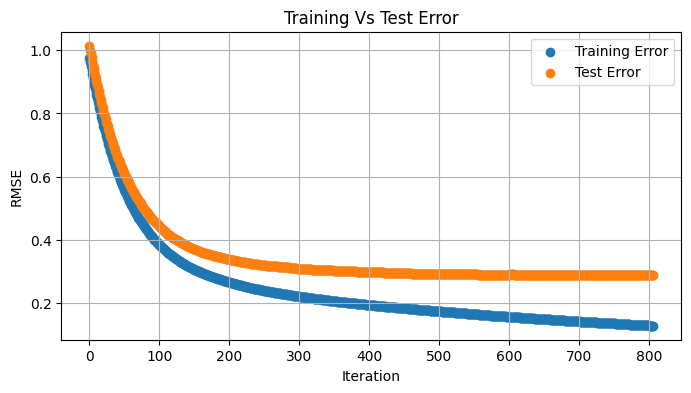

In [77]:
plt.figure(figsize=(8,4))
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Test Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Test Error')
plt.legend()
plt.show()

In [78]:
ypredicted = xgbmodel.predict(X_test)

In [79]:
ypredicted_casual = xgbmodel_casual.predict(X_test_casual)

In [80]:
ypredicted_registered = xgbmodel.predict(X_test_registered)

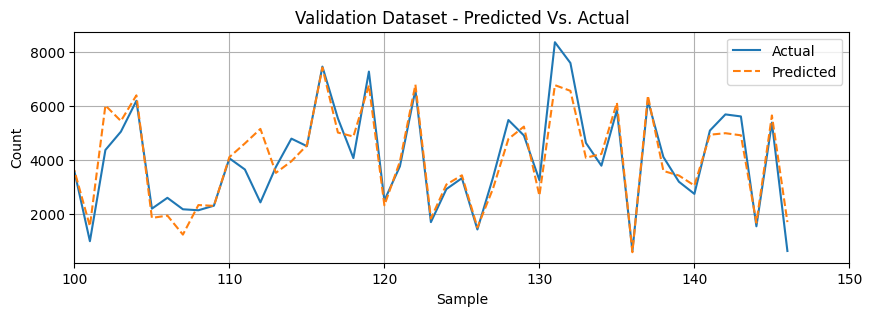

In [81]:
#rescale to review the counts
y_pred_rescaled = ypredicted * y_sd + y_mu
y_test_rescaled = y_test * y_sd + y_mu

plt.figure(figsize=(10,3))
# Actual Vs Predicted
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Count')
plt.xlim([100,150])
plt.title('Validation Dataset - Predicted Vs. Actual')
plt.legend()
plt.grid(True)
plt.show()

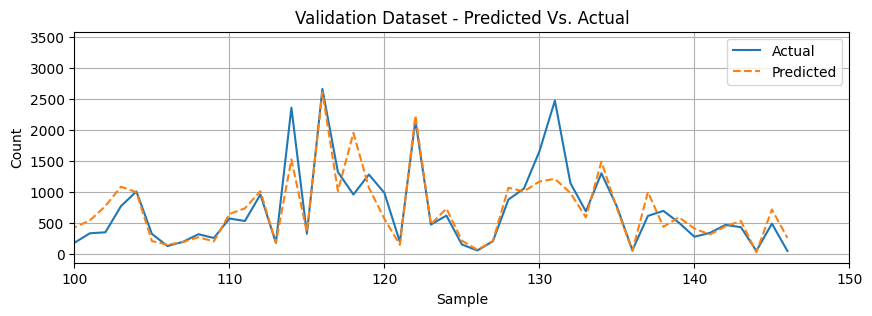

In [82]:
#rescale to review the counts
y_pred_rescaled_casual = ypredicted_casual * y_sd_casual + y_mu_casual
y_test_rescaled_casual = y_test_casual * y_sd_casual + y_mu_casual

plt.figure(figsize=(10,3))
# Actual Vs Predicted
plt.plot(y_test_rescaled_casual, label='Actual')
plt.plot(y_pred_rescaled_casual, label='Predicted', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Count')
plt.xlim([100,150])
plt.title('Validation Dataset - Predicted Vs. Actual')
plt.legend()
plt.grid(True)
plt.show()

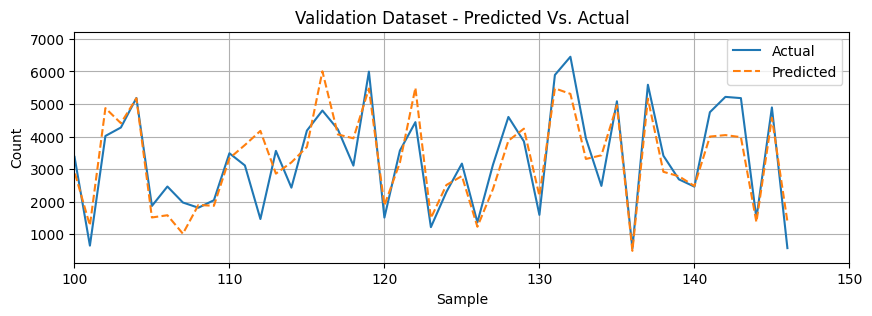

In [83]:
#rescale to review the counts
y_pred_rescaled_registered = ypredicted_registered * y_sd_registered + y_mu_registered
y_test_rescaled_registered = y_test_registered * y_sd_registered + y_mu_registered

plt.figure(figsize=(10,3))
# Actual Vs Predicted
plt.plot(y_test_rescaled_registered, label='Actual')
plt.plot(y_pred_rescaled_registered, label='Predicted', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Count')
plt.xlim([100,150])
plt.title('Validation Dataset - Predicted Vs. Actual')
plt.legend()
plt.grid(True)
plt.show()

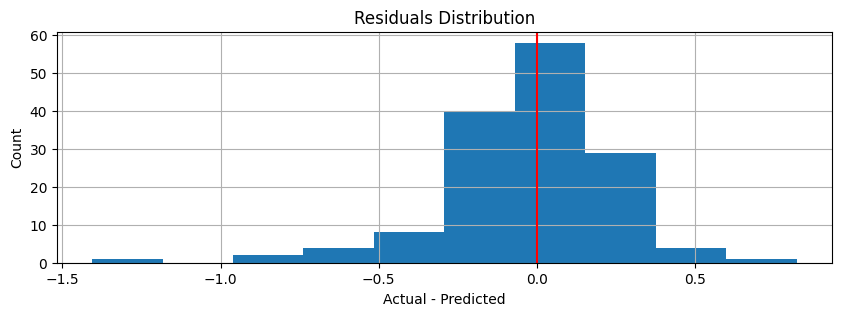

In [84]:
# Over prediction and Under Prediction needs to be balanced
# Training Data Residuals
residuals = (y_test - ypredicted)  #* y_sd + y_mu #(for actual cnt numbers)

plt.figure(figsize=(10,3))
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

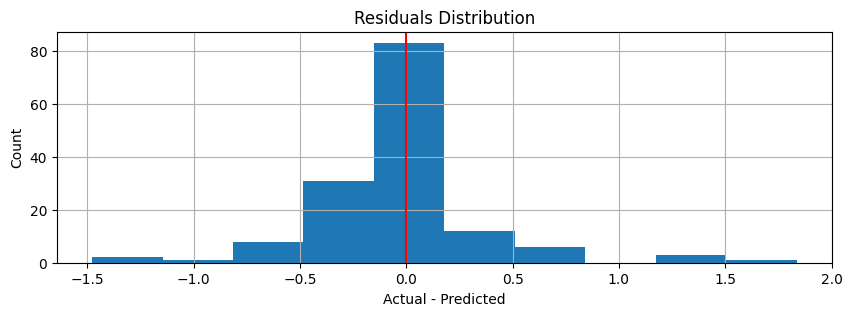

In [85]:
residuals = (y_test_casual - ypredicted_casual)  #* y_sd + y_mu #(for actual cnt numbers)

plt.figure(figsize=(10,3))
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

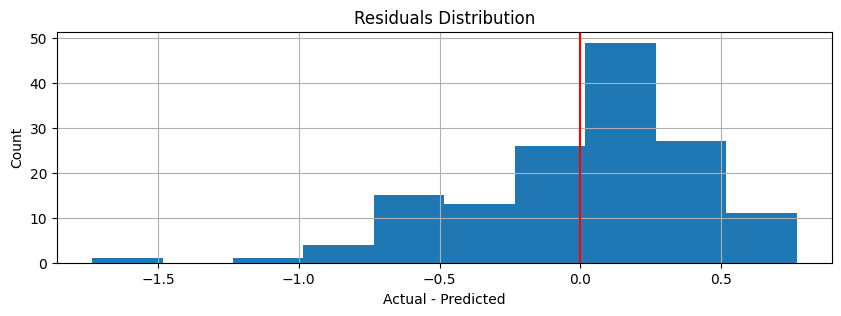

In [86]:
residuals = (y_test_registered - ypredicted_registered)  #* y_sd + y_mu #(for actual cnt numbers)

plt.figure(figsize=(10,3))
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Actual - Predicted')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

In [87]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    abs_error = np.abs(error)
    quadratic = np.minimum(abs_error, delta)
    linear = abs_error - quadratic
    return np.mean((0.5 * quadratic**2) + (delta * linear))

In [88]:
huber_loss = huber_loss(y_test, ypredicted)
print("Huber Loss: {0:0.4f}".format(huber_loss))

mse = mean_squared_error(y_test, ypredicted)
RMSE = np.sqrt(mse)
print("RMSE: {0:0.4f}".format(RMSE))

MAE = mean_absolute_error(y_test, ypredicted)
print("MAE: {0:0.4f}".format(MAE))

R2 = r2_score(y_test, ypredicted)
print("r2 score:", R2)

Huber Loss: 0.0378
RMSE: 0.2770
MAE: 0.1914
r2 score: 0.922105287637383


In [90]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    abs_error = np.abs(error)
    quadratic = np.minimum(abs_error, delta)
    linear = abs_error - quadratic
    return np.mean((0.5 * quadratic**2) + (delta * linear))

In [91]:
huber_loss = huber_loss(y_test_casual, ypredicted_casual)
print("Huber Loss: {0:0.4f}".format(huber_loss))

mse = mean_squared_error(y_test_casual, ypredicted_casual)
RMSE = np.sqrt(mse)
print("RMSE: {0:0.4f}".format(RMSE))

MAE = mean_absolute_error(y_test_casual, ypredicted_casual)
print("MAE: {0:0.4f}".format(MAE))

R2 = r2_score(y_test_casual, ypredicted_casual)
print("r2 score:", R2)

Huber Loss: 0.0757
RMSE: 0.4014
MAE: 0.2423
r2 score: 0.813949151272124


In [92]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    abs_error = np.abs(error)
    quadratic = np.minimum(abs_error, delta)
    linear = abs_error - quadratic
    return np.mean((0.5 * quadratic**2) + (delta * linear))

In [93]:
huber_loss = huber_loss(y_test_registered, ypredicted_registered)
print("Huber Loss: {0:0.4f}".format(huber_loss))

mse = mean_squared_error(y_test_registered, ypredicted_registered)
RMSE = np.sqrt(mse)
print("RMSE: {0:0.4f}".format(RMSE))

MAE = mean_absolute_error(y_test_registered, ypredicted_registered)
print("MAE: {0:0.4f}".format(MAE))

R2 = r2_score(y_test_registered, ypredicted_registered)
print("r2 score:", R2)

Huber Loss: 0.0795
RMSE: 0.4035
MAE: 0.3110
r2 score: 0.8403777812359938


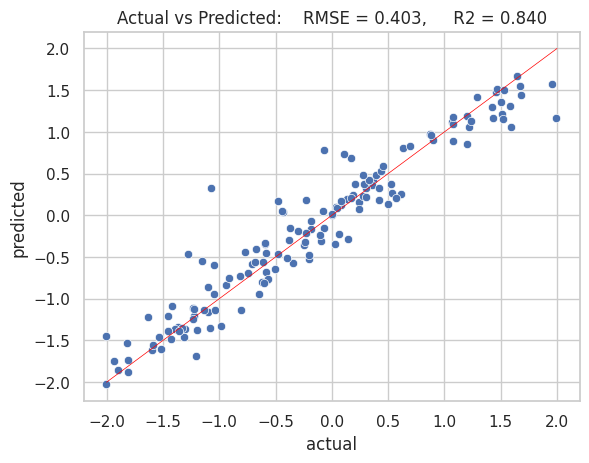

In [94]:
sb.set_theme(style="whitegrid")
plt.title('Actual vs Predicted:    RMSE = %s,     R2 = %s' % ('{:.3f}'.format(RMSE), '{:.3f}'.format(R2)))
plt.xlabel('actual')
plt.ylabel('predicted')
sb.lineplot(x=[-2, 2], y=[-2, 2], color='red', linewidth=0.5)
sb.scatterplot(x=y_test, y=ypredicted);

In [95]:
# Show the influencing features in order (with feature_importances_)
# Indicate which parameter used to decide the ranking of important features
important_features = pd.Series(data=xgbmodel.feature_importances_, index=NAMES)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

year_2011         0.201898
winter            0.170599
year_2012         0.165712
atemp             0.092758
temp              0.084388
fall              0.074951
lightsnow.rain    0.054347
clear             0.032543
hum               0.021830
month             0.018588
windspeed         0.013764
workingday_1      0.011847
workingday_0      0.010624
dayofweek         0.009021
cloudy            0.007746
day               0.007668
spring            0.006727
holiday_0         0.005826
summer            0.005361
holiday_1         0.003802
dtype: float32


In [96]:
important_features = pd.Series(data=xgbmodel.get_booster().get_score(importance_type='gain'), index=NAMES)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

year_2011         4.595092
winter            3.882738
year_2012         3.771518
atemp             2.111116
temp              1.920626
fall              1.705835
lightsnow.rain    1.236901
clear             0.740665
hum               0.496846
month             0.423062
windspeed         0.313257
workingday_1      0.269632
workingday_0      0.241793
dayofweek         0.205320
cloudy            0.176284
day               0.174516
spring            0.153114
holiday_0         0.132607
summer            0.122015
holiday_1         0.086534
dtype: float64


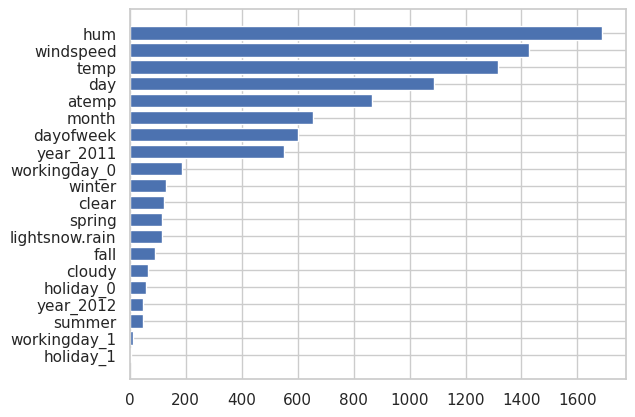

In [97]:
# Show the influencing features in order (with get_booster().get_fscore())
# fscore is based on the number of times a feature is used in a tree
fscore = xgbmodel.get_booster().get_fscore().items()
lists = sorted(fscore, key=lambda x:x[1]) # sorted by value, return a list of tuples
fkey, fvalue = zip(*lists) # unpack a list of pairs into two tuples

plt.barh(fkey, fvalue)
plt.show()

In [98]:
important_features_casual = pd.Series(data=xgbmodel_casual.feature_importances_, index=NAMES)
important_features_casual.sort_values(ascending=False,inplace=True)
print(important_features_casual)

workingday_1      0.380982
workingday_0      0.174018
dayofweek         0.054719
temp              0.048611
year_2011         0.039683
atemp             0.039425
lightsnow.rain    0.038599
winter            0.032567
year_2012         0.032055
month             0.024828
clear             0.018112
holiday_1         0.017667
holiday_0         0.017374
hum               0.016797
summer            0.016745
spring            0.015421
windspeed         0.013687
cloudy            0.008140
day               0.006230
fall              0.004338
dtype: float32


In [99]:
important_features_casual = pd.Series(data=xgbmodel_casual.get_booster().get_score(importance_type='gain'), index=NAMES)
important_features_casual.sort_values(ascending=False,inplace=True)
print(important_features_casual)

workingday_1      1.033232
workingday_0      0.471939
dayofweek         0.148399
temp              0.131834
year_2011         0.107621
atemp             0.106922
lightsnow.rain    0.104681
winter            0.088323
year_2012         0.086935
month             0.067333
clear             0.049119
holiday_1         0.047914
holiday_0         0.047119
hum               0.045554
summer            0.045413
spring            0.041823
windspeed         0.037121
cloudy            0.022076
day               0.016895
fall              0.011766
dtype: float64


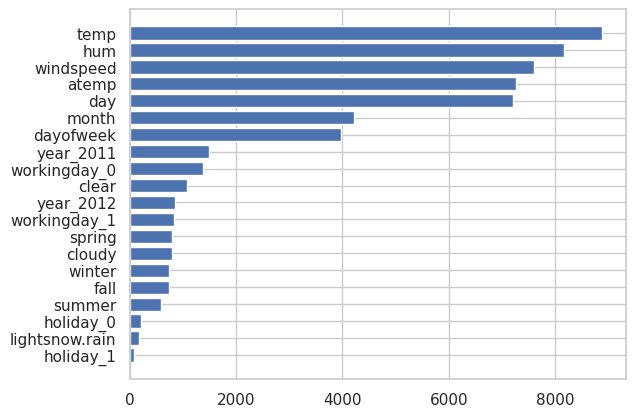

In [100]:
fscore = xgbmodel_casual.get_booster().get_fscore().items()
lists = sorted(fscore, key=lambda x:x[1]) # sorted by value, return a list of tuples
fkey, fvalue = zip(*lists) # unpack a list of pairs into two tuples

plt.barh(fkey, fvalue)
plt.show()

In [101]:
important_features_registered = pd.Series(data=xgbmodel_registered.feature_importances_, index=NAMES)
important_features_registered.sort_values(ascending=False,inplace=True)
print(important_features_registered)

winter            0.207480
year_2012         0.197169
year_2011         0.171074
workingday_1      0.144974
workingday_0      0.072593
fall              0.043726
lightsnow.rain    0.041403
temp              0.027074
clear             0.026697
atemp             0.023891
month             0.010083
summer            0.006815
hum               0.006745
holiday_0         0.004773
dayofweek         0.004750
windspeed         0.003878
day               0.003210
spring            0.002565
cloudy            0.001101
holiday_1         0.000000
dtype: float32


In [102]:
important_features_registered = pd.Series(data=xgbmodel_registered.get_booster().get_score(importance_type='gain'), index=NAMES)
important_features_registered.sort_values(ascending=False,inplace=True)
print(important_features_registered)

winter            4.746387
year_2012         4.510502
year_2011         3.913543
workingday_1      3.316470
workingday_0      1.660675
fall              1.000298
lightsnow.rain    0.947150
temp              0.619360
clear             0.610732
atemp             0.546531
month             0.230654
summer            0.155908
hum               0.154296
holiday_0         0.109182
dayofweek         0.108662
windspeed         0.088709
day               0.073439
spring            0.058672
cloudy            0.025198
holiday_1              NaN
dtype: float64


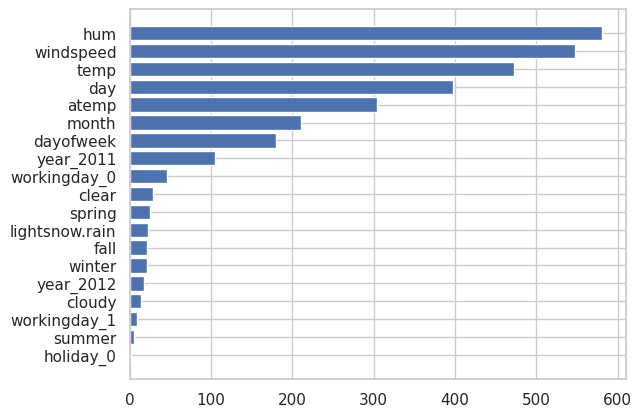

In [103]:
fscore = xgbmodel_registered.get_booster().get_fscore().items()
lists = sorted(fscore, key=lambda x:x[1]) # sorted by value, return a list of tuples
fkey, fvalue = zip(*lists) # unpack a list of pairs into two tuples

plt.barh(fkey, fvalue)
plt.show()